## Algoritmo Random Forest
- Previsão do posicionamento da Abelha Trigona Spinipes no período de 2021-2040, 2041-2060, 2061-80 e 2081-2100

### Configuração de Ambiente 


In [122]:
# Instalar dependências necessárias
# pip install pandas geopandas rasterio scikit-learn matplotlib streamlit folium streamlit-folium

In [123]:
# Importar bibliotecas (adicionando pathlib)
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import glob
import os
from pathlib import Path  # <<< IMPORTAMOS A BIBLIOTECA PATHLIB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings

# Ignorar avisos para uma saída mais limpa
warnings.filterwarnings('ignore')

# --- DEFINIÇÃO AUTOMÁTICA DOS CAMINHOS ---
# Esta linha mágica encontra o caminho da pasta do projeto automaticamente!
# Path.cwd() pega o diretório atual (.../abelhas_extensao/notebooks)
# .parent sobe um nível (.../abelhas_extensao)
BASE_DIR = Path.cwd().parent

# Definir os caminhos completos usando o operador / do pathlib
OCORRENCIAS_PATH = BASE_DIR / 'data' / 'ocorrencias.csv'
CLIMA_ATUAL_PATH = BASE_DIR / 'data' / 'clima_atual'
BRASIL_SHAPE_PATH = BASE_DIR / 'data' / 'BR_UF_2024'
PASTA_PREVISOES = BASE_DIR / 'data' / 'previsoes_futuras'

# Criar a pasta para salvar as previsões, se ela não existir
PASTA_PREVISOES.mkdir(parents=True, exist_ok=True)

print("Ambiente configurado e caminhos definidos automaticamente com pathlib!")
print(f"Pasta raiz do projeto encontrada: {BASE_DIR}")
print(f"Caminho do arquivo de ocorrências: {OCORRENCIAS_PATH}")

Ambiente configurado e caminhos definidos automaticamente com pathlib!
Pasta raiz do projeto encontrada: c:\Users\apoll\Documents\icev\extensao\abelhas_extensao
Caminho do arquivo de ocorrências: c:\Users\apoll\Documents\icev\extensao\abelhas_extensao\data\ocorrencias.csv


### Tratamento e Carregamento dos Dados


#### Carregar Dados de Ocorrência e Mapa do Brasil

In [124]:
# Carregar dados de ocorrência de forma robusta (VERSÃO FINAL CORRIGIDA)
try:
    print("Tentando carregar o arquivo 'ocorrencias.csv'...")
    ocorrencias_df_full = pd.read_csv(
        OCORRENCIAS_PATH,
        sep='\t',                     # <<< A MUDANÇA CHAVE! Diz ao pandas para usar tabulação como separador.
        comment='#',
        on_bad_lines='skip',
        low_memory=False,
        encoding='utf-8-sig'
    )
    
    # Agora, selecionamos apenas as colunas que nos interessamos e removemos valores nulos
    ocorrencias_df = ocorrencias_df_full[['decimalLatitude', 'decimalLongitude']].dropna()
    
    print("✅ Arquivo carregado com sucesso!")
    print(f"Total de pontos de ocorrência carregados: {len(ocorrencias_df)}")
    print(ocorrencias_df.head())

except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em '{OCORRENCIAS_PATH}'. Verifique se o caminho está correto.")
except KeyError:
    print("❌ Erro: As colunas 'decimalLatitude' ou 'decimalLongitude' não foram encontradas no arquivo.")
    print("Verifique os nomes das colunas no cabeçalho do seu CSV.")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado ao carregar o arquivo: {e}")

# Converter o DataFrame para um GeoDataFrame
gdf_ocorrencias = gpd.GeoDataFrame(
    ocorrencias_df,
    geometry=gpd.points_from_xy(ocorrencias_df.decimalLongitude, ocorrencias_df.decimalLatitude),
    crs="EPSG:4326"
)

# Carregar o mapa do Brasil (shapefile)
shapefile_brasil = glob.glob(os.path.join(BRASIL_SHAPE_PATH, "*.shp"))[0]
brasil_gdf = gpd.read_file(shapefile_brasil)

# Unir todos os estados em um único polígono do Brasil
brasil_poligono = brasil_gdf.unary_union

print("\nMapa do Brasil e pontos de ocorrência carregados com sucesso.")

Tentando carregar o arquivo 'ocorrencias.csv'...
✅ Arquivo carregado com sucesso!
Total de pontos de ocorrência carregados: 15244
   decimalLatitude  decimalLongitude
0          -9.2963          -75.9972
1         -23.4671          -56.4886
2         -23.4671          -56.4886
3         -23.4671          -56.4886
4         -23.4671          -56.4886

Mapa do Brasil e pontos de ocorrência carregados com sucesso.


#### Carregar e empilhar Dados Climáticos Atuais 

In [125]:
# Listar todos os arquivos .tif de clima atual, em ordem alfabética
clima_files = sorted(glob.glob(os.path.join(CLIMA_ATUAL_PATH, "*.tif")))

# Abrir o primeiro arquivo para obter metadados
with rasterio.open(clima_files[0]) as src:
    meta = src.meta

# Atualizar os metadados para o novo raster empilhado (agora com 19 bandas)
meta.update(count=len(clima_files))

# Criar o caminho para o arquivo empilhado
stack_path = os.path.join(CLIMA_ATUAL_PATH, "clima_atual_stack.tif")

# Empilhar os rasters em um único arquivo
with rasterio.open(stack_path, 'w', **meta) as dst:
    for i, file in enumerate(clima_files, 1):
        with rasterio.open(file) as src:
            dst.write(src.read(1), i)

print(f"Rasters climáticos atuais empilhados em: {stack_path}")

Rasters climáticos atuais empilhados em: c:\Users\apoll\Documents\icev\extensao\abelhas_extensao\data\clima_atual\clima_atual_stack.tif


#### Gerar Dados de Pseudo-Ausência
- Geramos pontos de pseudo-ausência em áreas aleatórias, mas longe dos pontos de presença, para treinar o modelo.

In [126]:
# --- VERSÃO MELHORADA PARA GERAR PSEUDO-AUSÊNCIAS ---
from shapely.geometry import Point

# Número de pontos de pseudo-ausência (mantemos o mesmo número)
num_pseudo_ausencias = len(gdf_ocorrencias) * 2

# Isso torna a tarefa de classificação mais realista e desafiadora
pseudo_ausencias_points = []
while len(pseudo_ausencias_points) < num_pseudo_ausencias:
    # Obter limites geográficos do Brasil
    minx, miny, maxx, maxy = brasil_poligono.bounds
    
    # Gerar um ponto aleatório dentro desses limites
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    
    # Verificar se o ponto está dentro do Brasil (sem a verificação de buffer)
    if brasil_poligono.contains(random_point):
        pseudo_ausencias_points.append(random_point)

# Criar um GeoDataFrame para as pseudo-ausências
gdf_pseudo_ausencias = gpd.GeoDataFrame(
    geometry=pseudo_ausencias_points,
    crs="EPSG:4326"
)

print(f"Gerados {len(gdf_pseudo_ausencias)} pontos de pseudo-ausência realistas em todo o Brasil.")

Gerados 30488 pontos de pseudo-ausência realistas em todo o Brasil.


#### Criar um Conjunto de Dados de Treinamento Final

In [127]:
# Função para extrair valores do raster para um GeoDataFrame
def extract_raster_values(gdf, raster_path):
    with rasterio.open(raster_path) as src:
        coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
        values = [val for val in src.sample(coords)]
    return np.array(values)

# Extrair valores para presenças e pseudo-ausências
valores_presenca = extract_raster_values(gdf_ocorrencias, stack_path)
valores_ausencia = extract_raster_values(gdf_pseudo_ausencias, stack_path)

# Criar o dataset final
X = np.vstack((valores_presenca, valores_ausencia))
y = np.array([1] * len(valores_presenca) + [0] * len(valores_ausencia))

# Nomes das features (bio1 a bio19)
feature_names = [os.path.basename(f).split('.')[0] for f in sorted(clima_files)]

# Criar um DataFrame para visualização
df_treinamento = pd.DataFrame(X, columns=feature_names)
df_treinamento['presenca'] = y

print("Conjunto de dados de treinamento criado:")
print(df_treinamento.head())
print(f"\nShape de X: {X.shape}, Shape de y: {y.shape}")

Conjunto de dados de treinamento criado:
         wc2        wc2        wc2     wc2    wc2   wc2        wc2     wc2  \
0  24.271093  24.590834  24.027500  2825.0  363.0  98.0  42.891392  1032.0   
1  23.157845  26.684959  19.153584  1513.0  184.0  57.0  34.639950   520.0   
2  23.157845  26.684959  19.153584  1513.0  184.0  57.0  34.639950   520.0   
3  23.157845  26.684959  19.153584  1513.0  184.0  57.0  34.639950   520.0   
4  23.157845  26.684959  19.153584  1513.0  184.0  57.0  34.639950   520.0   

     wc2    wc2     wc2        wc2        wc2         wc2        wc2  \
0  335.0  719.0  1020.0  11.812813  87.883148   28.844713  30.877750   
1  198.0  474.0   198.0  11.594021  57.734829  317.950592  32.429501   
2  198.0  474.0   198.0  11.594021  57.734829  317.950592  32.429501   
3  198.0  474.0   198.0  11.594021  57.734829  317.950592  32.429501   
4  198.0  474.0   198.0  11.594021  57.734829  317.950592  32.429501   

         wc2        wc2        wc2        wc2  presenca  

### Treinamento do Modelo Random Forest


#### Dividir os Dados e Treinar o Modelo

In [128]:
# --- VERSÃO MELHORADA: TREINAMENTO E AVALIAÇÃO ROBUSTA ---

# Preparar os dados de treino (mesmo código de antes)
valores_presenca = extract_raster_values(gdf_ocorrencias, stack_path)
valores_ausencia = extract_raster_values(gdf_pseudo_ausencias, stack_path)
X = np.vstack((valores_presenca, valores_ausencia))
y = np.array([1] * len(valores_presenca) + [0] * len(valores_ausencia))

# --- Validação Cruzada para uma Avaliação Mais Confiável ---
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Inicializar o modelo com parâmetros para reduzir overfitting
# max_depth: limita a profundidade das árvores
# min_samples_leaf: exige um número mínimo de amostras em uma folha
rf_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced',
    max_depth=15,          # <<< NOVO: Limita a complexidade
    min_samples_leaf=5     # <<< NOVO: Evita folhas muito específicas
)

print("Avaliando o modelo com Validação Cruzada (5 folds)...")
# StratifiedKFold mantém a proporção de classes em cada fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular a acurácia em cada fold
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

print(f"\nAcurácias em cada fold: {scores}")
print(f"Acurácia Média (CV): {scores.mean():.4f}")
print(f"Desvio Padrão da Acurácia: {scores.std():.4f}")

# Agora, treinamos o modelo final com TODOS os dados disponíveis
print("\nTreinando o modelo final com todos os dados...")
rf_model.fit(X, y)
print("Modelo final treinado!")

# Analisar a importância das variáveis (com o modelo final)
importancias = pd.DataFrame({
    'variavel': feature_names,
    'importancia': rf_model.feature_importances_
}).sort_values('importancia', ascending=False)

print("\nImportância das Variáveis Climáticas (modelo final):")
print(importancias)

Avaliando o modelo com Validação Cruzada (5 folds)...

Acurácias em cada fold: [0.97660435 0.9759484  0.97572709 0.97605511 0.97463372]
Acurácia Média (CV): 0.9758
Desvio Padrão da Acurácia: 0.0006

Treinando o modelo final com todos os dados...
Modelo final treinado!

Importância das Variáveis Climáticas (modelo final):
   variavel  importancia
14      wc2     0.131990
13      wc2     0.109207
2       wc2     0.076404
11      wc2     0.075896
7       wc2     0.060058
0       wc2     0.055506
17      wc2     0.055322
16      wc2     0.053263
12      wc2     0.043951
4       wc2     0.043144
18      wc2     0.040762
6       wc2     0.039238
1       wc2     0.038927
3       wc2     0.036331
15      wc2     0.034102
9       wc2     0.032633
10      wc2     0.028116
5       wc2     0.024452
8       wc2     0.020697


### Previsão para cenários futuros

#### Definir a Função de Previsão

In [129]:
def prever_cenario_para_brasil(cenario_file_path, modelo, output_path):
    """
    Versão final e corrigida: processa o raster global e recorta o resultado
    usando numpy, evitando o erro de arquivo fechado.
    """
    print(f"Processando o arquivo: {cenario_file_path.name}")
    
    # Carregar o mapa do Brasil
    brasil_gdf = load_brazil_map_notebook(BASE_DIR / 'data' / 'BR_UF_2024')

    # --- VERIFICAÇÕES E CORREÇÕES ROBUSTAS ---
    if brasil_gdf.empty:
        raise ValueError("O GeoDataFrame do Brasil está vazio. Verifique o arquivo shapefile.")

    if not brasil_gdf.is_valid.all():
        print("Aviso: Encontradas geometrias inválidas no shapefile. Tentando corrigir automaticamente...")
        brasil_gdf['geometry'] = brasil_gdf.geometry.buffer(0)
        if not brasil_gdf.is_valid.all():
            raise ValueError("Não foi possível corrigir as geometrias inválidas.")
        else:
            print("Geometrias corrigidas com sucesso.")
    
    # Abrir o raster para obter seu CRS e metadados
    with rasterio.open(cenario_file_path) as src:
        raster_crs = src.crs
        profile = src.profile

    # --- VERIFICAÇÃO E CORREÇÃO DE CRS ---
    if brasil_gdf.crs != raster_crs:
        print(f"Aviso: CRS do shapefile ({brasil_gdf.crs}) é diferente do CRS do raster ({raster_crs}).")
        print("Reprojetando o shapefile para o CRS do raster...")
        brasil_gdf = brasil_gdf.to_crs(raster_crs)
        print("Reprojeção concluída.")
    
    # Com o CRS alinhado, podemos calcular o polígono e os limites com segurança
    brasil_poligono = brasil_gdf.unary_union
    brasil_bounds = brasil_gdf.total_bounds

    # --- ESTRATÉGIA ROBUSTA: LER TUDO, MASCARAR E DEPOIS RECORTAR ---
    with rasterio.open(cenario_file_path) as src:
        # 1. Ler o raster global inteiro
        raster_data = src.read()
        
        # 2. Criar a máscara global
        mask = geometry_mask(
            [brasil_poligono], 
            out_shape=src.shape, 
            transform=src.transform, 
            invert=False
        )
        
    # 3. Preparar os dados para o modelo
    height, width = raster_data.shape[1], raster_data.shape[2]
    raster_data_reshaped = raster_data.reshape((raster_data.shape[0], -1)).T
    mask_flat = mask.reshape(-1)
    
    dados_brasil = raster_data_reshaped[~mask_flat]

    # Tratar valores NoData
    nodata_val = profile['nodata']
    if nodata_val is not None:
        dados_brasil[dados_brasil == nodata_val] = np.nan
    
    col_mean = np.nanmean(dados_brasil, axis=0)
    inds = np.where(np.isnan(dados_brasil))
    dados_brasil[inds] = np.take(col_mean, inds[1])

    print("Realizando a previsão para a área do Brasil...")
    previsao_brasil = modelo.predict_proba(dados_brasil)[:, 1]
    
    # 4. Reconstruir o mapa global (com NoData fora do Brasil)
    previsao_mapa_global = np.full(height * width, nodata_val, dtype=rasterio.float32)
    previsao_mapa_global[~mask_flat] = previsao_brasil
    previsao_mapa_global = previsao_mapa_global.reshape((height, width))

    # 5. RECORTAR O MAPA FINAL para o tamanho do Brasil
    # Criar uma janela de recorte usando as coordenadas do Brasil
    with rasterio.open(cenario_file_path) as src_recorte:
        # Criar janela com base nos limites do Brasil
        window_final = rasterio.windows.from_bounds(
            brasil_bounds[0], brasil_bounds[1], 
            brasil_bounds[2], brasil_bounds[3], 
            src_recorte.transform
        )
        
        # Calcular o novo transform para a janela recortada
        transform_recortado = src_recorte.window_transform(window_final)
    
    # Recortar o mapa de previsão usando índices da janela
    row_start = int(window_final.row_off)
    row_end = int(window_final.row_off + window_final.height)
    col_start = int(window_final.col_off)
    col_end = int(window_final.col_off + window_final.width)
    
    # Garantir que os índices não saiam dos limites
    row_start = max(0, row_start)
    row_end = min(height, row_end)
    col_start = max(0, col_start)
    col_end = min(width, col_end)
    
    previsao_mapa_recortada = previsao_mapa_global[row_start:row_end, col_start:col_end]
    
    # Atualizar o perfil para o arquivo de saída (recortado)
    profile.update({
        'height': previsao_mapa_recortada.shape[0],
        'width': previsao_mapa_recortada.shape[1],
        'transform': transform_recortado,
        'dtype': rasterio.float32,
        'count': 1,
        'compress': 'lzw'
    })
    
    # Salvar o mapa de previsão recortado
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(previsao_mapa_recortada, 1)

#### Executar as Previsões para todos os Períodos 

In [132]:
# --- EXECUTAR AS PREVISÕES (VERSÃO FOCADA NO BRASIL) ---

import time
from datetime import datetime

# O caminho para a pasta que contém os arquivos .tif de cenários futuros
cenario_files_path = BASE_DIR / 'data' / 'clima_futuro'

# Definir a ordem EXATA dos cenários
ordem_dos_cenarios = [
    "wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif",
    "wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2041-2060.tif",
    "wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2061-2080.tif",
    "wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2081-2100.tif"
]

print("=" * 80)
print("INICIANDO PROCESSAMENTO DOS CENÁRIOS CLIMÁTICOS FUTUROS")
print("=" * 80)
print(f"Data/Hora: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Total de cenários: {len(ordem_dos_cenarios)}\n")

# Contador de sucessos e falhas
processados_com_sucesso = 0
falhas = []

# Timer geral
inicio_geral = time.time()

for idx, nome_do_arquivo in enumerate(ordem_dos_cenarios, 1):
    cenario_file = cenario_files_path / nome_do_arquivo
    
    print(f"\n{'─' * 80}")
    print(f"[{idx}/{len(ordem_dos_cenarios)}] PROCESSANDO: {cenario_file.name}")
    print(f"{'─' * 80}")
    
    if cenario_file.exists():
        try:
            # Timer individual
            inicio = time.time()
            
            # Definir nome do arquivo de saída
            periodo_nome = cenario_file.stem
            output_filename = f"previsao_trigona_{periodo_nome}.tif"
            output_path = PASTA_PREVISOES / output_filename
            
            # Chamar a função de previsão
            prever_cenario_para_brasil(cenario_file, rf_model, output_path)
            
            # Calcular tempo de processamento
            tempo_decorrido = time.time() - inicio
            
            print(f"✅ SUCESSO!")
            print(f"   ⏱️  Tempo: {tempo_decorrido:.2f} segundos")
            print(f"   💾 Salvo em: {output_path.name}")
            
            processados_com_sucesso += 1
            
        except Exception as e:
            print(f"❌ ERRO ao processar {nome_do_arquivo}")
            print(f"   Detalhes: {str(e)}")
            falhas.append((nome_do_arquivo, str(e)))
    else:
        print(f"⚠️  AVISO: Arquivo não encontrado!")
        print(f"   Caminho esperado: {cenario_file}")
        falhas.append((nome_do_arquivo, "Arquivo não encontrado"))

# Tempo total
tempo_total = time.time() - inicio_geral

# Relatório final
print("\n" + "=" * 80)
print("RELATÓRIO FINAL DO PROCESSAMENTO")
print("=" * 80)
print(f"✅ Processados com sucesso: {processados_com_sucesso}/{len(ordem_dos_cenarios)}")
print(f"❌ Falhas: {len(falhas)}")
print(f"⏱️  Tempo total: {tempo_total:.2f} segundos ({tempo_total/60:.2f} minutos)")

if falhas:
    print("\n⚠️  ARQUIVOS COM PROBLEMAS:")
    for arquivo, erro in falhas:
        print(f"   • {arquivo}")
        print(f"     Motivo: {erro}")
else:
    print("\n🎉 TODOS OS CENÁRIOS FORAM PROCESSADOS COM SUCESSO!")

print(f"\n💾 Localização dos resultados:")
print(f"   {PASTA_PREVISOES}")
print("=" * 80)

INICIANDO PROCESSAMENTO DOS CENÁRIOS CLIMÁTICOS FUTUROS
Data/Hora: 06/11/2025 17:43:47
Total de cenários: 4


────────────────────────────────────────────────────────────────────────────────
[1/4] PROCESSANDO: wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif
────────────────────────────────────────────────────────────────────────────────
Processando o arquivo: wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif
Aviso: CRS do shapefile (EPSG:4674) é diferente do CRS do raster (EPSG:4326).
Reprojetando o shapefile para o CRS do raster...
Reprojeção concluída.
Realizando a previsão para a área do Brasil...
✅ SUCESSO!
   ⏱️  Tempo: 7.65 segundos
   💾 Salvo em: previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif

────────────────────────────────────────────────────────────────────────────────
[2/4] PROCESSANDO: wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2041-2060.tif
────────────────────────────────────────────────────────────────────────────────
Processando o arquivo: wc2.1_10m_bioc_BCC-CSM

### Visualização da Previsão

GERANDO VISUALIZAÇÕES DOS MAPAS DE PREVISÃO

✅ Encontrados 4 mapas de previsão

📊 Opção 1: Visualizações Individuais (alta qualidade)
--------------------------------------------------------------------------------
[1/4] Processando: previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif


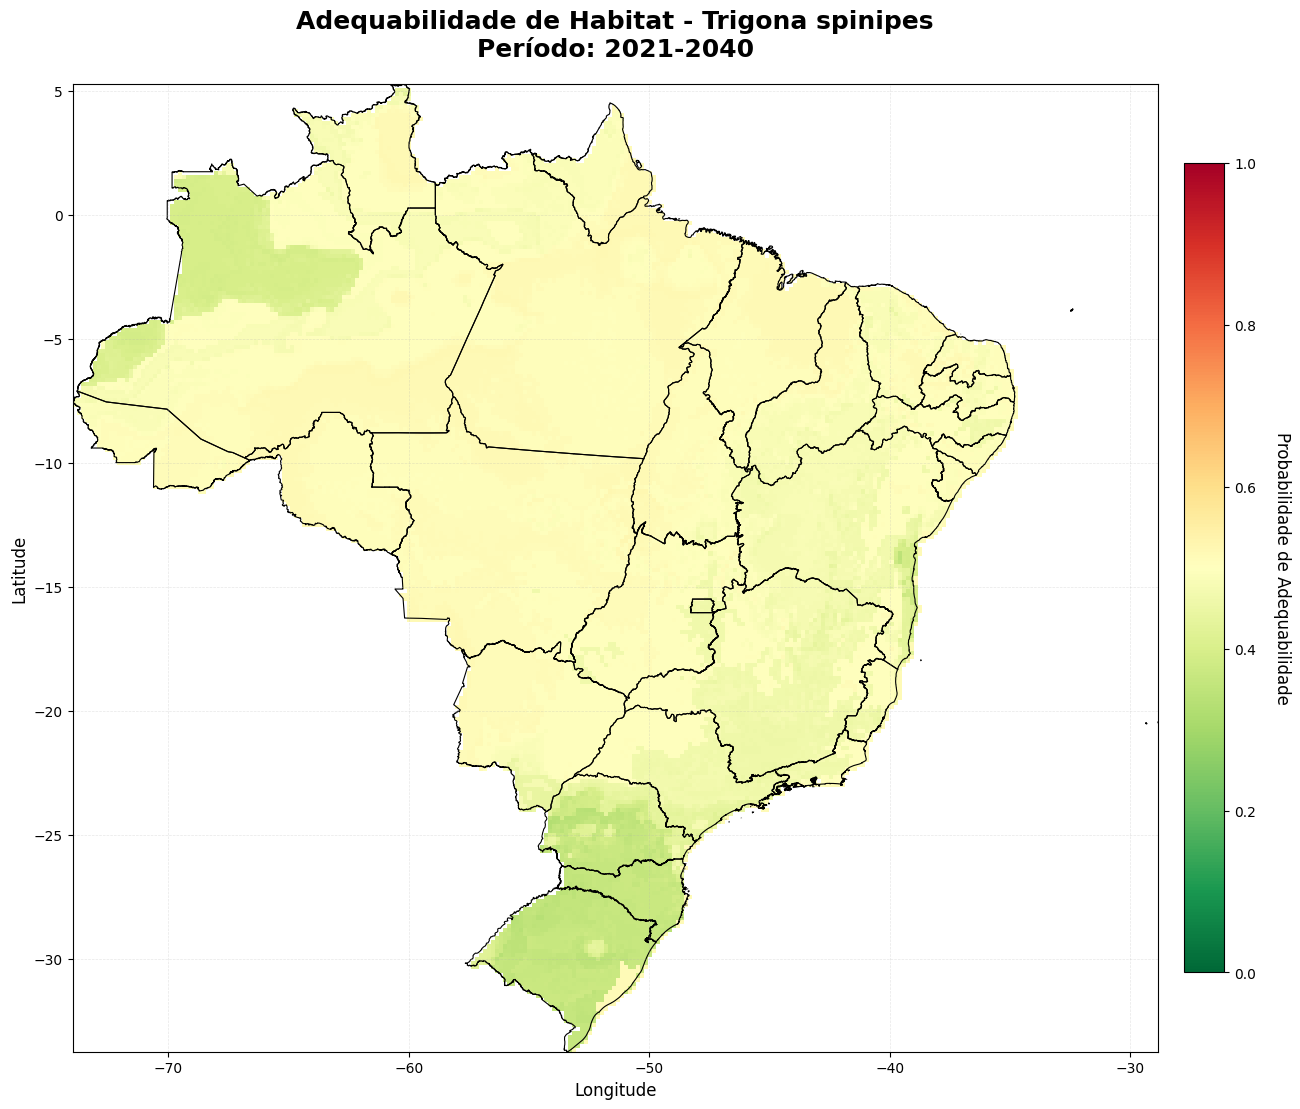

   ✅ Visualizado com sucesso!

[2/4] Processando: previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2041-2060.tif


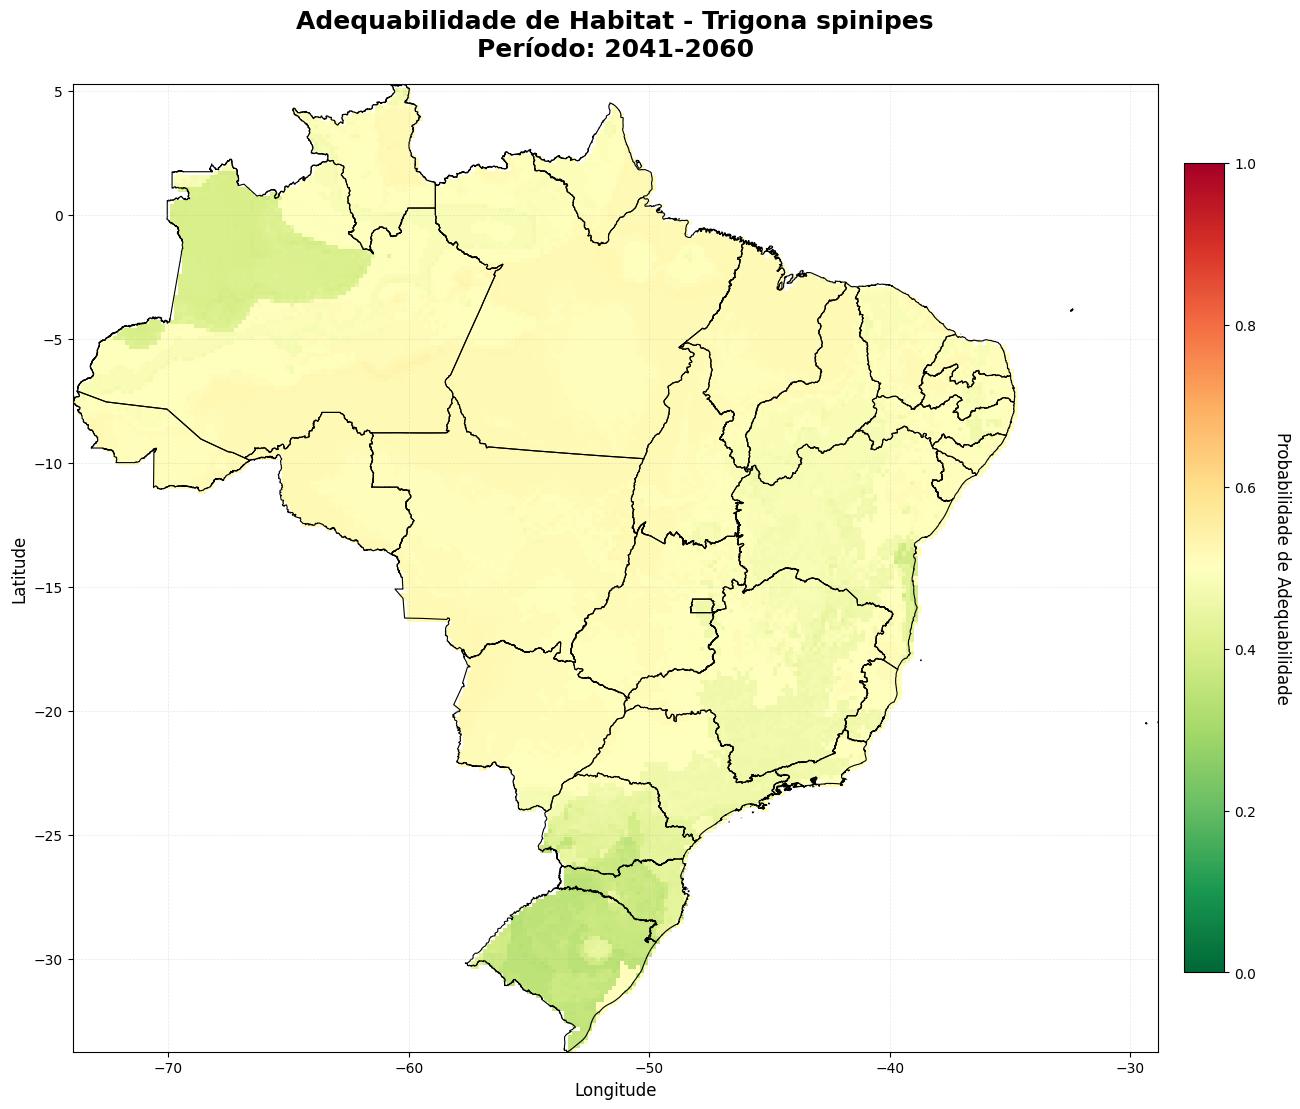

   ✅ Visualizado com sucesso!

[3/4] Processando: previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2061-2080.tif


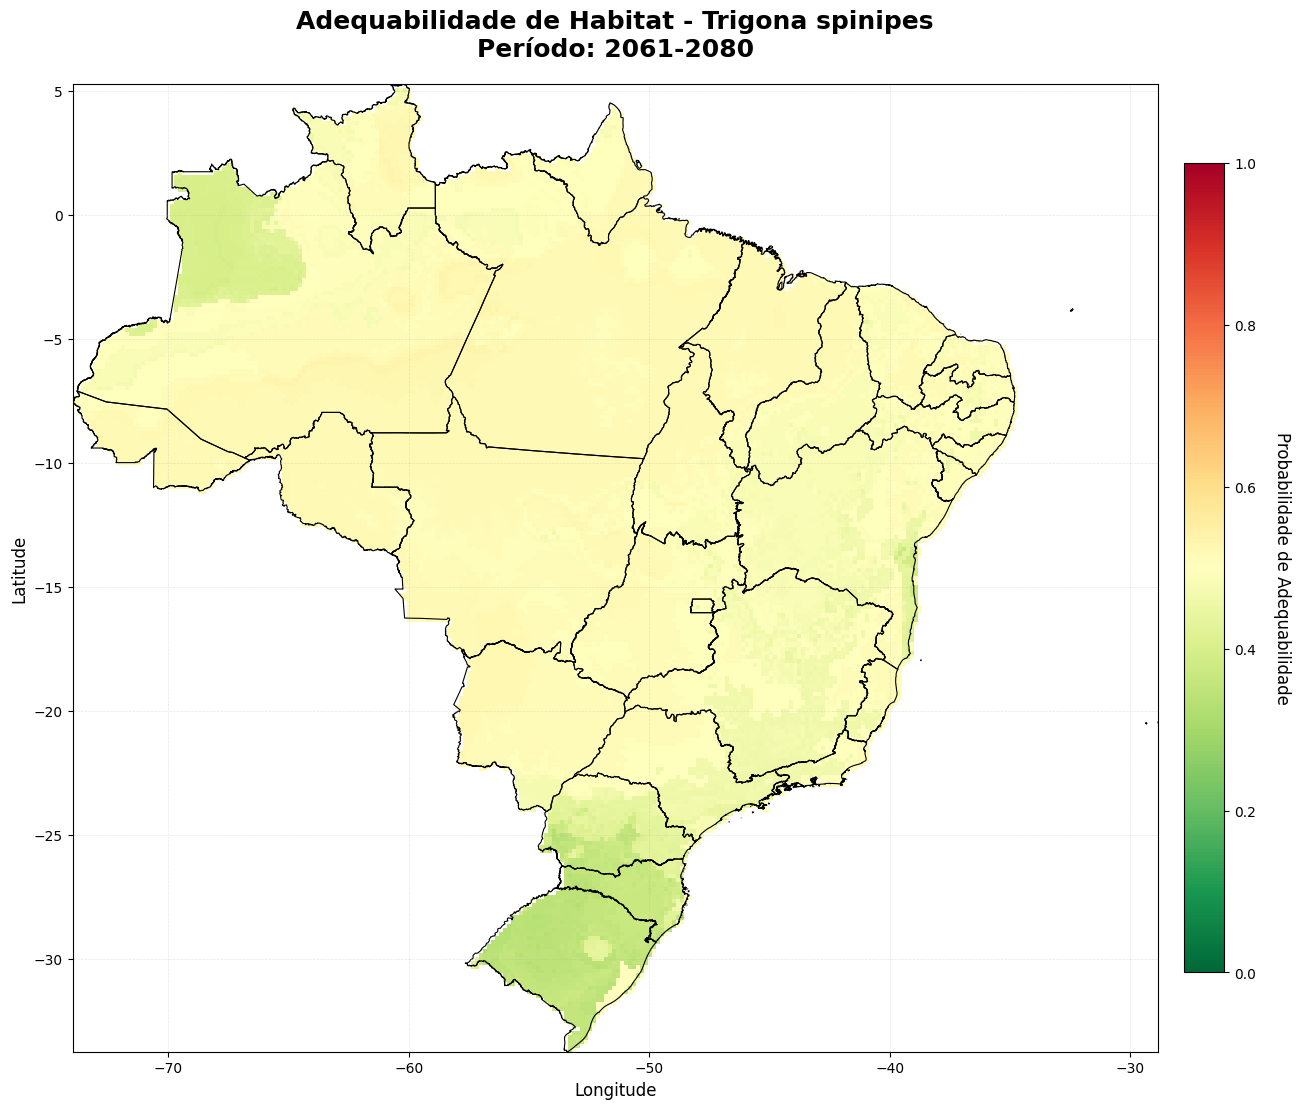

   ✅ Visualizado com sucesso!

[4/4] Processando: previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2081-2100.tif


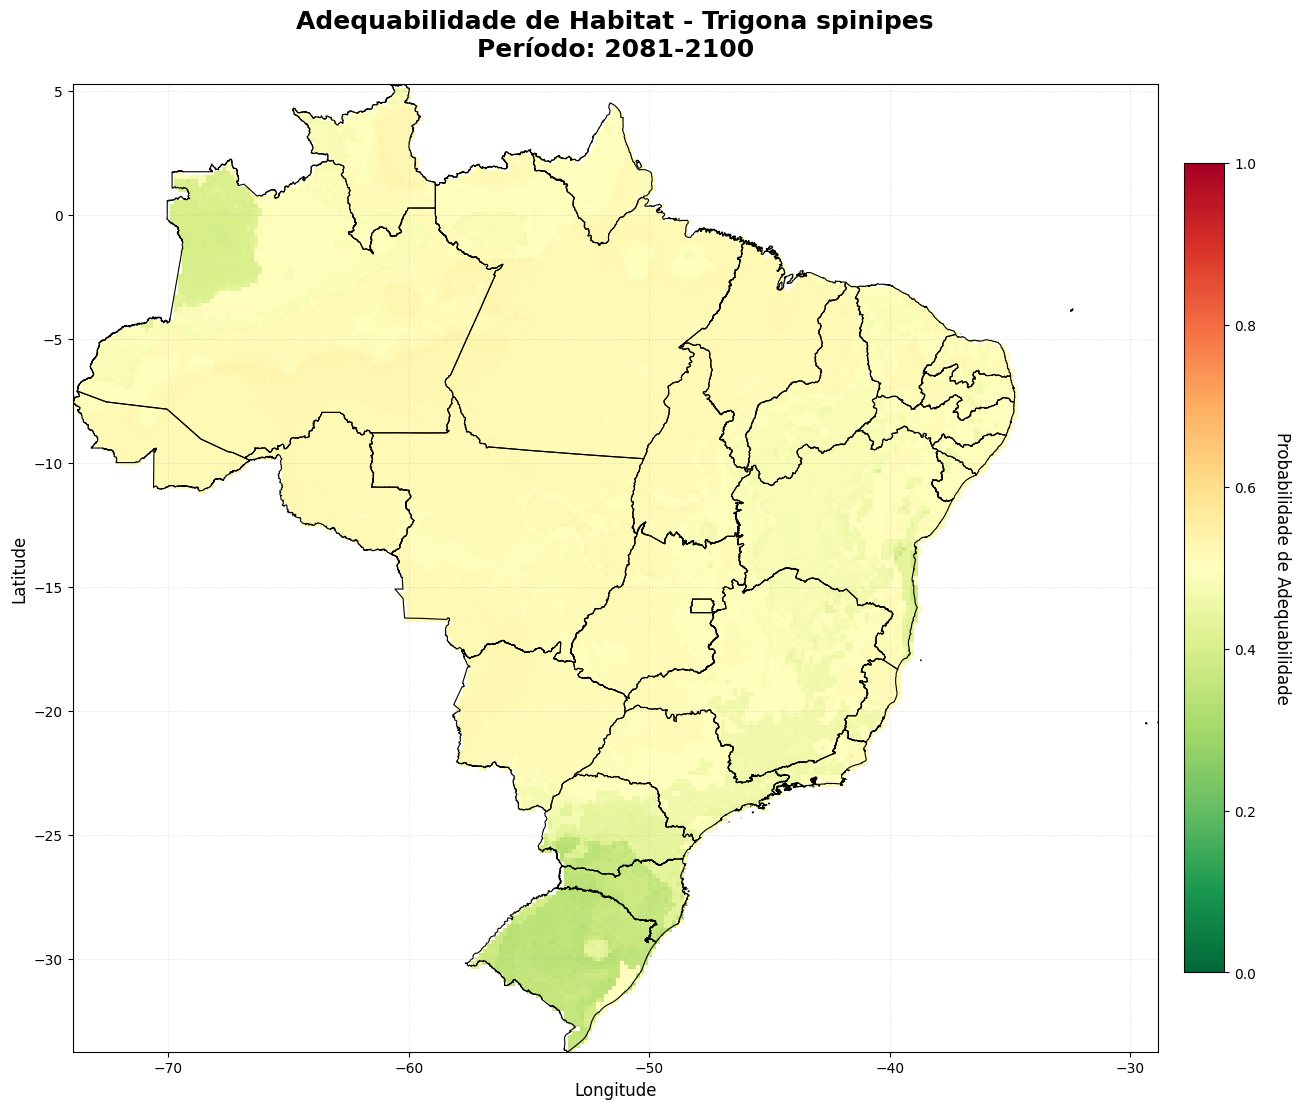

   ✅ Visualizado com sucesso!


📊 Opção 2: Visualização Comparativa (grid 2x2)
--------------------------------------------------------------------------------
   ✅ [1/4] 2021-2040
   ✅ [2/4] 2041-2060
   ✅ [3/4] 2061-2080
   ✅ [4/4] 2081-2100


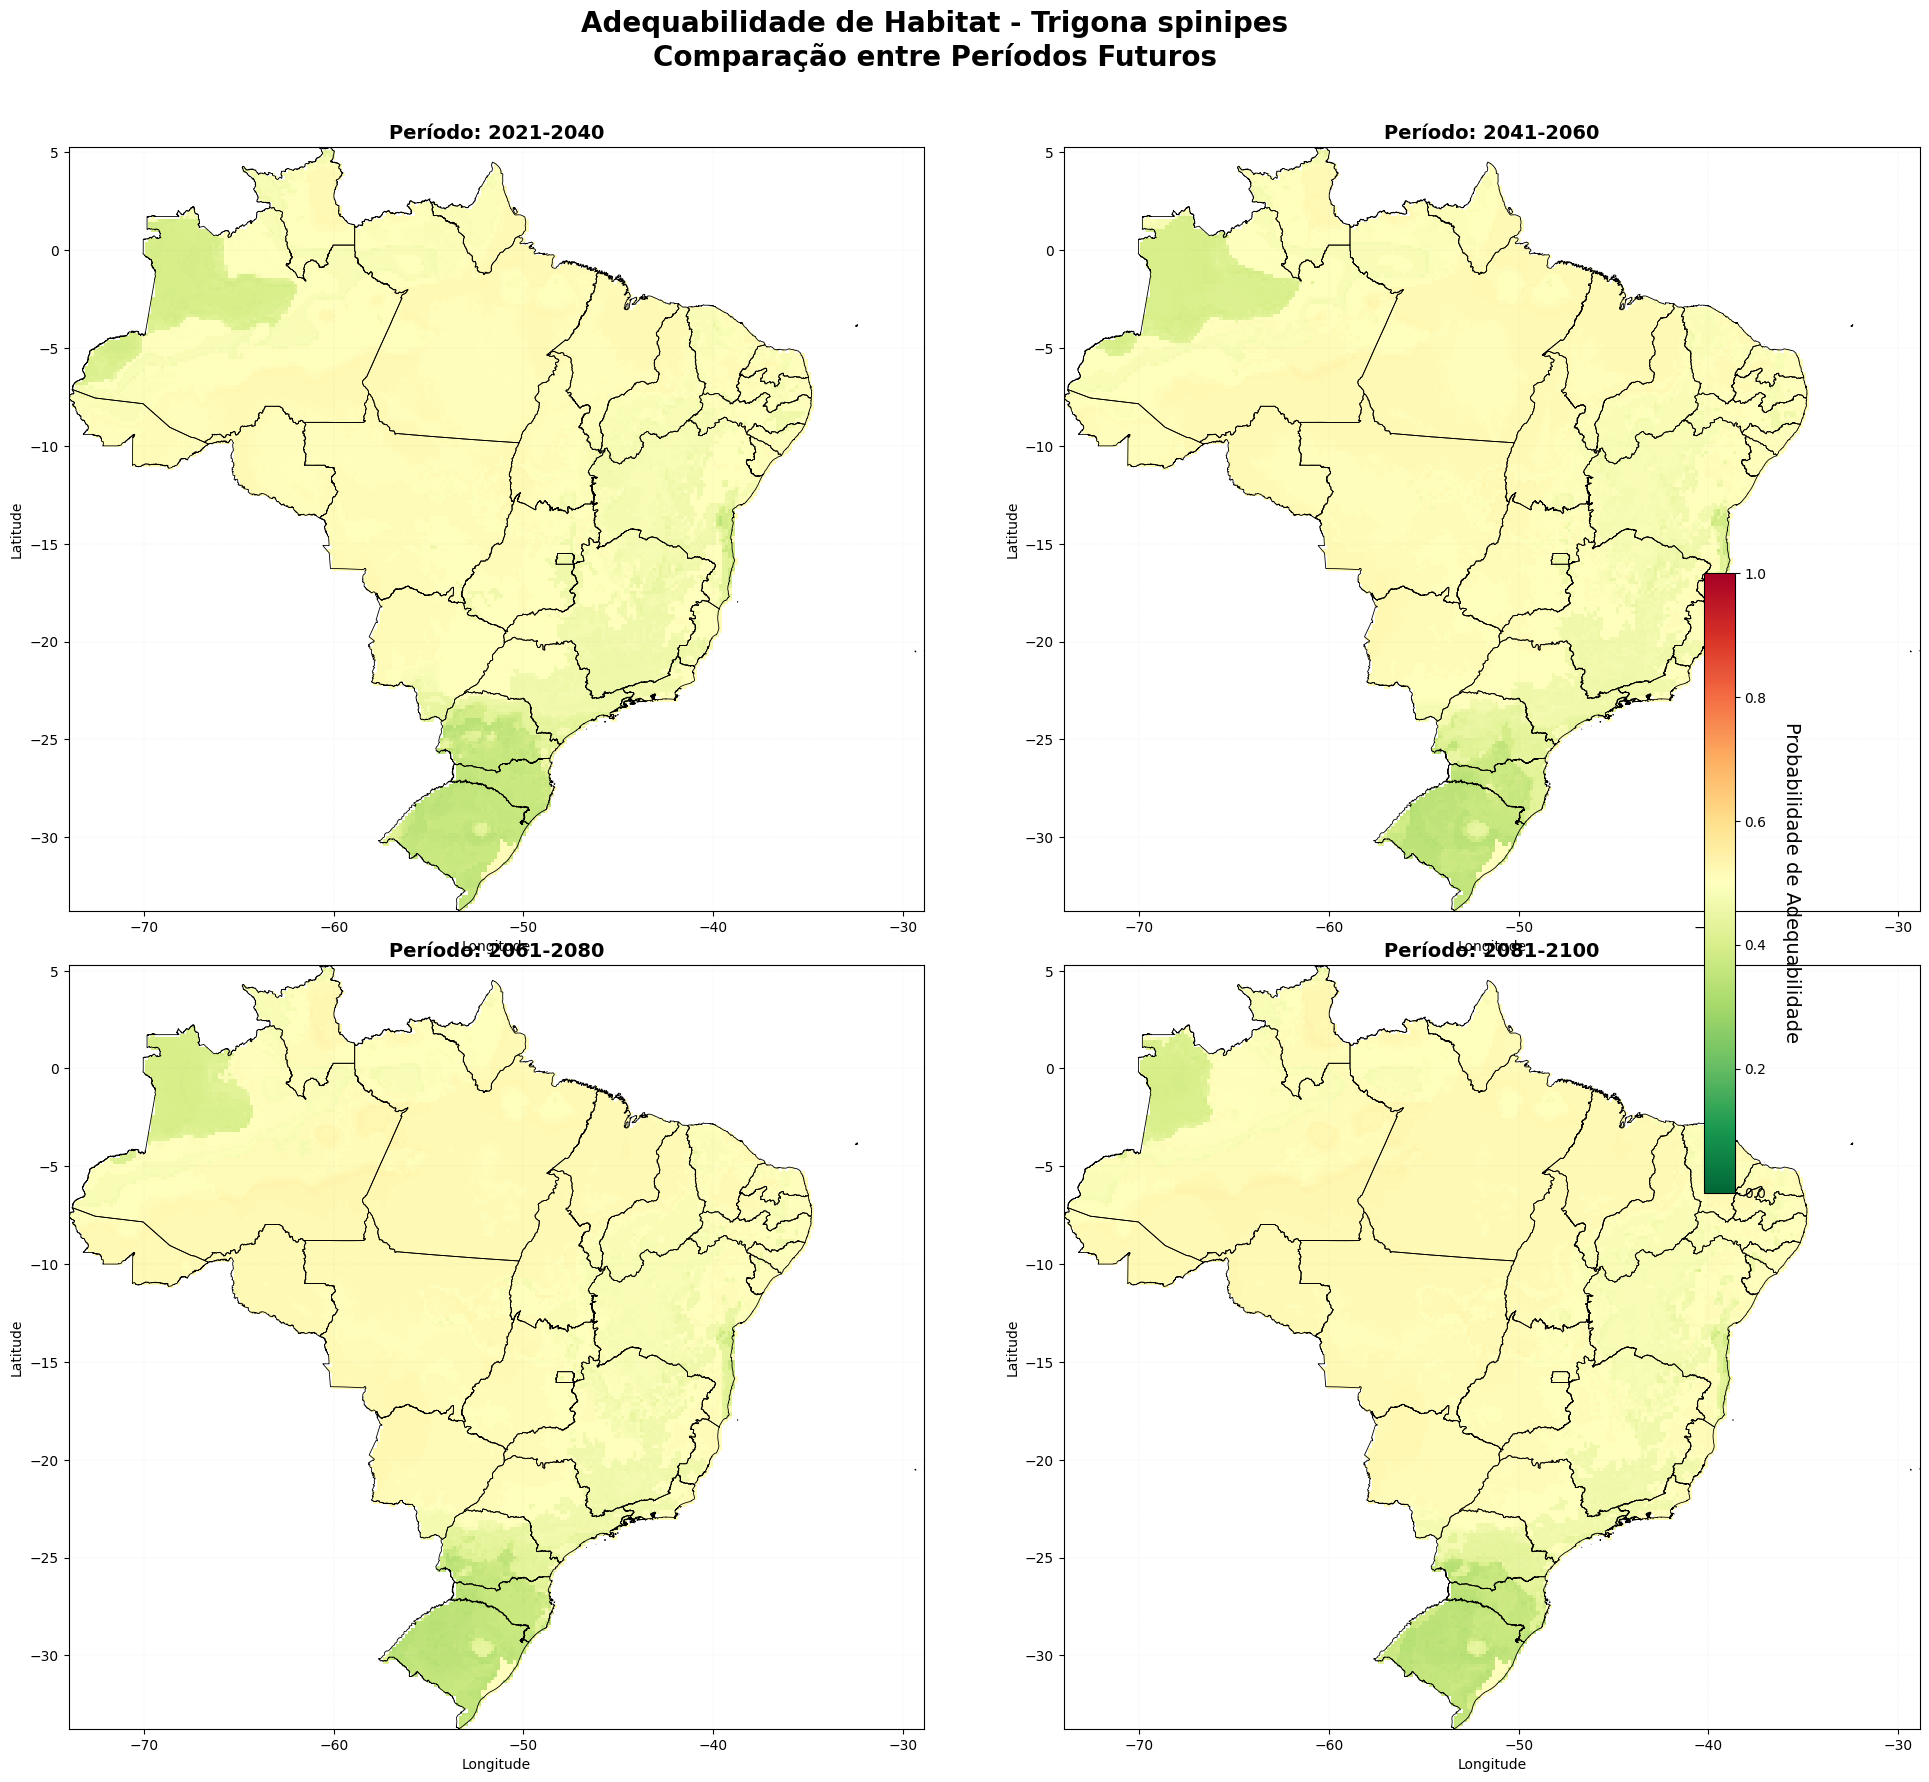


✅ Visualização comparativa concluída!

✅ PROCESSO DE VISUALIZAÇÃO CONCLUÍDO!


In [135]:
# --- VISUALIZAR TODOS OS MAPAS DE PREVISÃO ---

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from pathlib import Path

print("=" * 80)
print("GERANDO VISUALIZAÇÕES DOS MAPAS DE PREVISÃO")
print("=" * 80)

# Buscar todos os arquivos .tif na pasta de previsões
mapas_previsao = sorted(PASTA_PREVISOES.glob("previsao_trigona_*.tif"))

if not mapas_previsao:
    print("\n⚠️  Nenhum mapa de previsão encontrado!")
    print(f"📁 Pasta verificada: {PASTA_PREVISOES}")
else:
    print(f"\n✅ Encontrados {len(mapas_previsao)} mapas de previsão\n")
    
    # Carregar o mapa do Brasil (uma vez só, para reaproveitar)
    brasil_gdf = load_brazil_map_notebook(BASE_DIR / 'data' / 'BR_UF_2024')
    brasil_bounds = brasil_gdf.total_bounds
    
    # Configuração do mapa de cores
    cmap = plt.get_cmap('RdYlGn_r')
    norm = colors.Normalize(vmin=0, vmax=1)
    
    # =========================================================================
    # OPÇÃO 1: VISUALIZAÇÃO INDIVIDUAL (um mapa por vez, melhor qualidade)
    # =========================================================================
    print("📊 Opção 1: Visualizações Individuais (alta qualidade)")
    print("-" * 80)
    
    for idx, mapa_path in enumerate(mapas_previsao, 1):
        print(f"[{idx}/{len(mapas_previsao)}] Processando: {mapa_path.name}")
        
        try:
            with rasterio.open(mapa_path) as src:
                previsao_data = src.read(1)
            
            # Extrair período do nome do arquivo
            # Ex: "previsao_trigona_wc2.1_10m_bioc_BCC-CSM2-MR_ssp245_2021-2040.tif"
            nome_arquivo = mapa_path.stem
            if '2021-2040' in nome_arquivo:
                periodo = '2021-2040'
            elif '2041-2060' in nome_arquivo:
                periodo = '2041-2060'
            elif '2061-2080' in nome_arquivo:
                periodo = '2061-2080'
            elif '2081-2100' in nome_arquivo:
                periodo = '2081-2100'
            else:
                periodo = 'Período Desconhecido'
            
            # Criar figura individual
            fig, ax = plt.subplots(figsize=(14, 12))
            
            # Plotar o raster
            im = ax.imshow(previsao_data, cmap=cmap, norm=norm, 
                          extent=[brasil_bounds[0], brasil_bounds[2], 
                                 brasil_bounds[1], brasil_bounds[3]])
            
            # Adicionar contorno do Brasil
            brasil_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)
            
            # Configurar título e labels
            ax.set_title(f"Adequabilidade de Habitat - Trigona spinipes\nPeríodo: {periodo}", 
                        fontsize=18, fontweight='bold', pad=20)
            ax.set_xlabel("Longitude", fontsize=12)
            ax.set_ylabel("Latitude", fontsize=12)
            
            # Ajustar limites
            ax.set_xlim(brasil_bounds[0], brasil_bounds[2])
            ax.set_ylim(brasil_bounds[1], brasil_bounds[3])
            
            # Adicionar colorbar
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)
            cbar.set_label('Probabilidade de Adequabilidade', rotation=270, labelpad=25, fontsize=12)
            
            # Adicionar grid sutil
            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
            
            plt.tight_layout()
            plt.show()
            
            print(f"   ✅ Visualizado com sucesso!\n")
            
        except Exception as e:
            print(f"   ❌ Erro ao processar: {str(e)}\n")
    
    # =========================================================================
    # OPÇÃO 2: VISUALIZAÇÃO COMPARATIVA (todos juntos em uma grid)
    # =========================================================================
    print("\n" + "=" * 80)
    print("📊 Opção 2: Visualização Comparativa (grid 2x2)")
    print("-" * 80)
    
    if len(mapas_previsao) >= 2:
        # Determinar layout da grid
        n_mapas = len(mapas_previsao)
        if n_mapas <= 2:
            nrows, ncols = 1, 2
        elif n_mapas <= 4:
            nrows, ncols = 2, 2
        else:
            nrows, ncols = 3, 2
        
        # Criar figura com subplots
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 18))
        axes = axes.flatten() if n_mapas > 1 else [axes]
        
        for idx, (mapa_path, ax) in enumerate(zip(mapas_previsao, axes)):
            try:
                with rasterio.open(mapa_path) as src:
                    previsao_data = src.read(1)
                
                # Extrair período
                nome_arquivo = mapa_path.stem
                if '2021-2040' in nome_arquivo:
                    periodo = '2021-2040'
                elif '2041-2060' in nome_arquivo:
                    periodo = '2041-2060'
                elif '2061-2080' in nome_arquivo:
                    periodo = '2061-2080'
                elif '2081-2100' in nome_arquivo:
                    periodo = '2081-2100'
                else:
                    periodo = 'Período Desconhecido'
                
                # Plotar
                im = ax.imshow(previsao_data, cmap=cmap, norm=norm,
                             extent=[brasil_bounds[0], brasil_bounds[2],
                                    brasil_bounds[1], brasil_bounds[3]])
                
                brasil_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.6)
                
                ax.set_title(f"Período: {periodo}", fontsize=14, fontweight='bold')
                ax.set_xlabel("Longitude", fontsize=10)
                ax.set_ylabel("Latitude", fontsize=10)
                ax.set_xlim(brasil_bounds[0], brasil_bounds[2])
                ax.set_ylim(brasil_bounds[1], brasil_bounds[3])
                ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.3)
                
                print(f"   ✅ [{idx+1}/{n_mapas}] {periodo}")
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Erro ao carregar\n{mapa_path.name}', 
                       ha='center', va='center', transform=ax.transAxes)
                print(f"   ❌ Erro: {str(e)}")
        
        # Remover axes extras se houver
        for idx in range(len(mapas_previsao), len(axes)):
            fig.delaxes(axes[idx])
        
        # Título geral
        fig.suptitle('Adequabilidade de Habitat - Trigona spinipes\nComparação entre Períodos Futuros', 
                    fontsize=20, fontweight='bold', y=0.98)
        
        # Colorbar compartilhada
        cbar = fig.colorbar(im, ax=axes, orientation='vertical', 
                           fraction=0.02, pad=0.02, shrink=0.8)
        cbar.set_label('Probabilidade de Adequabilidade', 
                      rotation=270, labelpad=25, fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        print("\n✅ Visualização comparativa concluída!")
    else:
        print("⚠️  Necessário pelo menos 2 mapas para visualização comparativa")

print("\n" + "=" * 80)
print("✅ PROCESSO DE VISUALIZAÇÃO CONCLUÍDO!")
print("=" * 80)